# Problem Set 4 - Random Numbers - comments/solutions

### Programming for Economists Autumn 2025: Classes 5 & 9
**Matias BF Hall**

**Table of contents**<a id='toc0_'></a>    
- 1. [RNG Warm-up (Reproducibility Basics)](#toc1_)    
- 2. [Simulate the chain and estimate steady state unemployment (2-States)](#toc2_)    
  - 2.1. [Single Worker](#toc2_1_)    
  - 2.2. [Many Workers](#toc2_2_)    
- 3. [Spell lengths: Simulation vs. Theory](#toc3_)    
  - 3.1. [Simulation-based Spells](#toc3_1_)    
  - 3.2. [Theoretical Spells](#toc3_2_)    
- 4. [From hazards to a 2×2 transition matrix](#toc4_)    
- 5. [Power iteration (compute the stationary distribution)](#toc5_)    
  - 5.1. [Implementing the function](#toc5_1_)    
  - 5.2. [Implementing the function \& comparison to closed form](#toc5_2_)    
- 6. [3-state extension](#toc6_)    
  - 6.1. [Simulate a 3-state path](#toc6_1_)    
  - 6.2. [Build the 3-state transition matrix and compute stationary unemployment](#toc6_2_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## 1. <a id='toc1_'></a>[RNG Warm-up (Reproducibility Basics)](#toc0_)

**Goal.** Create reproducible draws; understand *seed vs stream*.

- Create `rng = np.random.default_rng(2025)`.
- Draw 5 uniforms and 5 normals.
- Re-create the same sequence by constructing a **new** generator with the same seed.
- Show that **calling the same generator twice** advances the stream (different outputs).



In [ ]:
import numpy as np

# Starter (safe to run)
rng = np.random.default_rng(2025)
u1 = rng.random(5)
z1 = rng.standard_normal(5)

rng_same = np.random.default_rng(2025)
# Task: Reproduce the first draws from the same seed
u2 = rng_same.random(5)
z2 = rng_same.standard_normal(5)

# Stream progression (same generator again)
u_next = rng.random(5)
z_next = rng.standard_normal(5)

# Print first draws
print("First uniform draws u1:", u1)
print("First standard normal draws z1:", z1)

# Check that u1 equals u2 and z1 equals z2
print("u1 equals u2:", np.allclose(u1, u2))
print("z1 equals z2:", np.allclose(z1, z2))

# Print the next draws
print("Next uniform draws:", u_next)
print("Next standard normal draws:", z_next)


# As we see the draws where we refresh the generator with the same seed are identical
# The next draws continue the sequence from the first generator
# That is we have moved down the stream after the first 5 draws,
# so even though we started at the same seed, the next draws are different

First uniform draws u1: [0.99445781 0.38200974 0.82714801 0.83725528 0.97580901]
First standard normal draws z1: [ 0.7653914  -0.75970935  0.26699619  0.70178085  0.29212132]
u1 equals u2: True
z1 equals z2: True
Next uniform draws: [0.38954302 0.23021956 0.16696115 0.15343643 0.9740917 ]
Next standard normal draws: [-0.3924407  -0.67731696  2.93601077 -0.66462723  1.25746344]


## 2. <a id='toc2_'></a>[Simulate the chain and estimate steady state unemployment (2-States)](#toc0_)

**Goal.** Simulate the two-state Markov chain with transition matrix
$$
P=\begin{pmatrix}1-s & s\\ f & 1-f\end{pmatrix},
$$
produce a path of states $x_t\in\{0,1\}$ with $0=\text{E}$, $1=\text{U}$, and use the simulated time average to estimate the steady state unemployment share. Compare it to the theoretical stationary value from Exercise 3, $\pi_U^*=\frac{s}{s+f}$.

**Intuition**?
 Think of each period, a worker is in one state (e.g., **Employed** `E` or **Unemployed** `U`).  
 - A **transition probability** tells you how likely it is to go from one state to another next period (e.g., `P(E→U)` is the job‑separation rate, `P(U→E)` is the job‑finding rate).  
 - Over time, repeatedly applying the transition matrix generates a **Markov chain**. Simulating with random numbers just means:  
   1) For each individual and period, draw a uniform number `u ~ U[0,1]`.  
   2) Compare `u` to the relevant row of the transition matrix to decide the next state.  


### 2.1. <a id='toc2_1_'></a>[Single Worker](#toc0_)

**Goal.** Simulate a single worker who is hit by random shocks each period:

If Employed ($E$), a bad shock causes separation to Unemployment ($U$) with probability $s$.

If Unemployed ($U$), a good shock leads to job finding back to $E$ with probability $f$.
No formulas—just randomness that switches states.

**Task: Implement the following:**

1. Pick inputs: horizon $T$, separation probability $s$, job-finding probability $f$, initial state $s_0 \in {0,1}$ (encode $0=E$, $1=U$), and a seed.

2. For each period $t=0,\dots,T-1$, draw one uniform $\epsilon_t \sim \mathrm{U}[0,1]$ and apply:

  - If in $E$: set next state to $U$ if $\epsilon_t < s$, else stay in $E$.
  - If in $U$: set next state to $E$ if $\epsilon_t < f$, else stay in $U$.

3. Store the whole path of length $T+1$ and report the share of time in $U$ (the mean, since $U=1$).


**Hints**  

- Use $0=E$, $1=U$ so averages give unemployment directly.
- One fresh random draw per worker per period.
- Start small ($T=20$, $N=5$) to print and check; then scale up.
- Set a seed for reproducibility while debugging.

In [ ]:
# Set the number of periods, N=5 must be a mistake by Jeppe since we only want 1 worker
# Also defining E and U, and s and f
T = 20
N = 1
E = 0.0
U = 1.0
s = 0.2
f = 0.2


# This is a very basic and slow function where I loop over each period and each worker
# See Brigitte's solution for a more efficient vectorized version
def unemployment_simulation(T, N, s, f):
    # Simulate productivity draws for N workers over T periods
    # Initialize random number generator for replicability
    rng = np.random.default_rng(2025)
    draw = rng.random((T, N))

    # initialise state arrays - here everyone is employed at t=0
    states = np.zeros((T+1, N))

    # we loop over each period
    for t in range(T):
        # and each worker
        for n in range(N):
            if states[t, n] == E:
                # if employed, check if they become unemployed
                if draw[t, n] < s:
                    states[t+1, n] = U
                else:
                    states[t+1, n] = E
            else:
                # if unemployed, check if they become employed
                if draw[t, n] < f:
                    states[t+1, n] = E
                else:
                    states[t+1, n] = U
    return states, draw

# Run the simulation
states, draw = unemployment_simulation(T, N, s, f)

# Print the states and draws and unemployment rate
print("States over time:\n", states[:,0])
print("unemployment rate", np.mean(states))


States over time:
 [0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 0. 0. 0.]
unemployment rate 0.47619047619047616


### 2.2. <a id='toc2_2_'></a>[Many Workers](#toc0_)

- Next, simulate $N$ (e.g. 20,000) workers in parallel (one uniform per worker per period) and print the unemployment rate over time.

In [ ]:
# Use the function above
T = 1000
N = 20_000
s = 0.05
f = 0.2

states, draw = unemployment_simulation(T, N, s, f)

u_rate_periods = np.mean(states, axis=1)
print("Average unemployment rate over time:", np.mean(u_rate_periods))


Average unemployment rate over time: 0.19906643356643358


## 3. <a id='toc3_'></a>[Spell lengths: Simulation vs. Theory](#toc0_)

**Goal.** From a simulated path of states ($0=E$, $1=U$), measure how long unemployment and employment spells last. Think of a spell as a streak: consecutive $U$’s is one unemployment spell; consecutive $E$’s is one employment spell. Then compare your measured averages to what you’d expect if shocks hit with constant per-period chances:
- Unemployment spells end when a good shock arrives (probability $f$ per period).
- Employment spells end when a bad shock arrives (probability $s$ per period).
So the “typical” spell length should be about $1/f$ for $U$ and $1/s$ for $E$.

### 3.1. <a id='toc3_1_'></a>[Simulation-based Spells](#toc0_)

**Tasks.** 

1. Get a path: simulate a state path of length $T+1$ using your $s$ and $f$ (or reuse your earlier simulation for the many worker case). Encode $0=E$ and $1=U$.

2. Identify spells as streaks:
        - An unemployment spell is a run of 1’s (e.g., ... 0 1 1 1 0 ... has one $U$ spell of length 3).
        - An employment spell is a run of 0’s.
        - We ignore right-censored final spells (a trailing run that does not end within the sample).

3. Measure lengths: scan the path and record the length of each run of 1’s (for $U$) and each run of 0’s (for $E$).        


In [ ]:
# create function to compute spell lengths
def spell_lengths(states, status):
    # create list to store spell lengths and set initial value at zero
    lengths = []
    spell = 0
    #loop over each worker
    for n in range (N):
        #loop over each period for that worker
        for x in states[:,n]:
            # check if in the desired status and add one to spell if we are
            if x == status:
                spell += 1
            else:
            # if we leave the status, store the spell length if >0 and reset spell
                if spell > 0:
                    lengths.append(spell)
                    spell = 0
    return lengths

In [33]:
# Get values
U_spell = np.array(spell_lengths(states, U))
E_spell = np.array(spell_lengths(states, E))

# Compute averages
avg_U_spell = np.mean(U_spell)
avg_E_spell = np.mean(E_spell)

# Print
print(f"Unemployment spells: count={U_spell.size:,}, mean={avg_U_spell:.3f}, theory~{1/f:.3f}")
print(f"Employment   spells: count={E_spell.size:,}, mean={avg_E_spell:.3f}, theory~{1/s:.3f}")

Unemployment spells: count=800,949, mean=4.976, theory~5.000
Employment   spells: count=800,949, mean=20.020, theory~20.000


### 3.2. <a id='toc3_2_'></a>[Theoretical Spells](#toc0_)

1. Compare your simulation based spells to the geometric predictions, i.e.
- Unemployment spell length is geometric with mean $\mathbb{E}[T_U]=1/f$.
- Employment spell length is geometric with mean $\mathbb{E}[T_E]=1/s$.

2. Plot histograms of $U$- and $E$-spell lengths and overlay the geometric pmf with parameters $f$ and $s$.

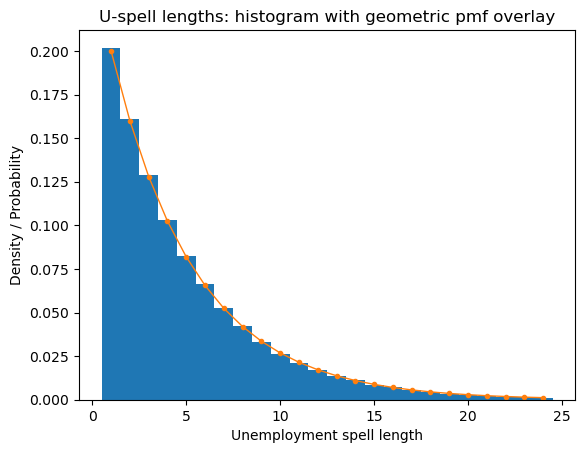

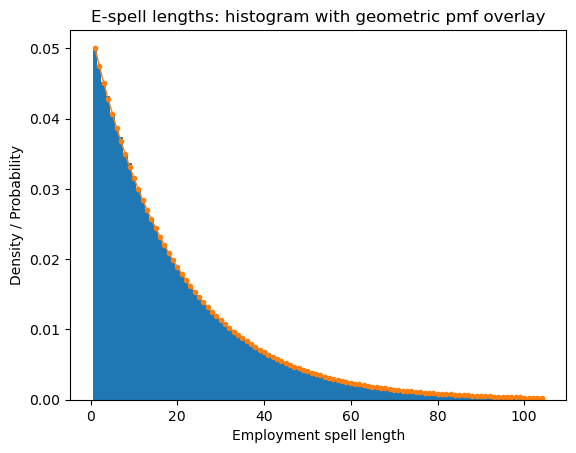

In [ ]:
# This is simply Brigitte's plotting code with a few comments

import matplotlib.pyplot as plt
# 3) Geometric pmf overlays
def geometric_pmf(k, p):
    """PMF for length k >= 1 with per-period exit prob p."""
    k = np.asarray(k)
    return (1 - p)**(k - 1) * p


# Choose x-ranges that cover most of the mass
# We do this to avoid outliers distorting the x-axis range
kU_max = int(np.percentile(U_spell, 99.5))  # robust upper bound
kE_max = int(np.percentile(E_spell, 99.5))
# We make arrays with all the lengths we want and then compute the geometric pmf values
kU = np.arange(1, max(2, kU_max + 1))
kE = np.arange(1, max(2, kE_max + 1))
pmf_U = geometric_pmf(kU, f)
pmf_E = geometric_pmf(kE, s)


# Cosmetic choices
# Controls
bin_w = 1.0      # bins (try 0.25 for even finer)
line_w = 1.0     # thickness of overlay line
ms = 3           # marker size

# 4) Plots: histogram (density) + pmf overlay
# U-spells
plt.figure()
plt.hist(U_spell, bins=np.arange(0.5, kU.max() + 1.5, bin_w), density=True)
plt.plot(kU, pmf_U, marker='o', linewidth=line_w, markersize=ms)
plt.xlabel("Unemployment spell length")
plt.ylabel("Density / Probability")
plt.title("U-spell lengths: histogram with geometric pmf overlay")
plt.show()

# E-spells
plt.figure()
plt.hist(E_spell, bins=np.arange(0.5, kE.max() + 1.5, bin_w), density=True)
plt.plot(kE, pmf_E, marker='o', linewidth=line_w, markersize=ms)
plt.xlabel("Employment spell length")
plt.ylabel("Density / Probability")
plt.title("E-spell lengths: histogram with geometric pmf overlay")
plt.show()

**Interpretation.** Discuss briefly the economic intuition of what you have computed and what the plots show.

 - Shorter spells are the most likely


## 4. <a id='toc4_'></a>[From hazards to a 2×2 transition matrix](#toc0_)

Let $s\in(0,1)$ be the probability to lose one's job (separation probability - transition from E to U) and $f\in(0,1)$ the job-finding probability (transition from U to E):
$$
P = \begin{pmatrix}
1-s & s\\\\
f & 1-f
\end{pmatrix}.
$$

**Matrix Interpretation**  
- States: `E=0` (employed), `U=1` (unemployed).  
- Rows = current state, columns = next state.  
  - From `E`: stay employed with prob `1−s`, move to `U` with prob `s`.  
  - From `U`: find a job with prob `f`, stay unemployed with prob `1−f`.  
- $P$ is **row-stochastic**: each row sums to 1 and all entries are in $[0,1]$.

**Your tasks**  
1. Implement `make_P_2state(s, f)` returning the matrix above.  
2. Validate that entries are in $[0,1]$ and each row sums to 1.


In [36]:
# Very little adjustment from the given starter code
def make_P_2state(s, f):
    """Return a 2x2 row-stochastic transition matrix for E=0, U=1.
    """
    assert 0.0 <= s <= 1.0 and 0.0 <= f <= 1.0, "Probabilities must be in [0,1]."
    # TODO: implement
    P = np.array([[1.0-s, s],
                  [f, 1.0-f]], dtype=float)
    assert np.allclose(P.sum(axis=1), 1.0), "Rows must sum to 1."
    return P

# Validator will be defined in solution; checks follow there.


## 5. <a id='toc5_'></a>[Power iteration (compute the stationary distribution)](#toc0_)

**Idea.** Think of $\mu^{(t)}$ as the share of people in each state at time $t$.
If everyone follows the same transition rules $P$, then next period’s shares are
$$
\mu^{(t+1)} \;=\; \mu^{(t)} P
$$
If you keep applying this update, the shares typically settle down to a fixed vector $\pi$ that doesn’t change when you multiply by $P$. That $\pi$ is the stationary distribution.


### 5.1. <a id='toc5_1_'></a>[Implementing the function](#toc0_)

**Task.** 

- Implement a function `stationary_power(P, tol=1e-12, maxit=1_000_000, mu0=None)` that returns `(mu, iters)` where:
  - `P` is an $n\times n$ **row-stochastic** matrix (each row sums to 1, entries in $[0,1]$).
  - `mu0` is an optional initial distribution $\mu^{(0)}$ (shape `(n,)`); if `None`, use the uniform vector.
  - Start from any probability vector $\mu^{(0)}$ (e.g., uniform).
  - Repeatedly update $\mu \leftarrow \mu P$.
  - Stop when $|\mu^{(t+1)}-\mu^{(t)}|_\infty < \texttt{tol}$ (the biggest absolute change in any entry is small).
  - Return the final $\mu$ (renormalized to sum to 1) and how many iterations it took.


In [41]:
def stationary_power(P,tol=1e-12,maxit=1_000_000,mu0=None):
    #if no initial distribution is given, start with uniform
    if mu0 is None:
        mu0 = np.ones(P.shape[0]) / P.shape[0]
    it = 0
    # loop until convergence or max iterations reached
    while it < maxit:
        mu = mu0 @ P
        if np.linalg.norm(mu - mu0,ord=np.inf) < tol:
            return mu, it
        # update for next iteration
        mu0 = mu
        it += 1
    print("Max iterations reached")
    return mu, maxit

### 5.2. <a id='toc5_2_'></a>[Implementing the function \& comparison to closed form](#toc0_)

**Task.** 

1. **Apply the function.** Use your function `stationary_power(P, tol, maxit, mu0)` to obtain
   $$
   (\pi,\ \texttt{iters}), \qquad \pi=(\pi_E,\pi_U), \quad \pi=\pi P,\quad \pi_E+\pi_U=1.
   $$
   Report \(\pi_U\) (the stationary unemployment rate) and the iteration count.

2. **Closed-form benchmark.** Compute the theoretical steady state implied by the hazards:
   $$
   \pi_U^{\text{cf}}=\frac{s}{s+f}
   $$

3. **Compare.** Verify numerically that
   $$
   \bigl|\pi_U - \pi_U^{\text{cf}}\bigr| \;<\; 10^{-10}
   $$


In [46]:
# set s and f and compute P
s = 0.05
f = 0.2
P = make_P_2state(s, f)

# compute stationary distribution and theoretical
pi, iterations = stationary_power(P)

pi_U_theory = s/(s + f)

# compare and print results
assert np.isclose(pi[1], pi_U_theory), "Stationary unemployment rate does not match theory."
print(f"Stationary distribution computed in {iterations} iterations: {pi}")

Stationary distribution computed in 88 iterations: [0.8 0.2]


## 6. <a id='toc6_'></a>[3-state extension](#toc0_)

**Setup.** States are encoded as **`E=0`** (employed), **`U=1`** (short-term unemployed), **`L=2`** (long-term unemployed).

### 6.1. <a id='toc6_1_'></a>[Simulate a 3-state path](#toc0_)

**Goal.** Simulate a panel of workers over time where each worker gets one random shock per period and moves according to the current row of a $3\times3$ transition matrix.

**Inputs.**
Horizon $T$, workers $N$, probabilities per period $s$ ($E\!\to\!U$), $f_s$ ($U\!\to\!E$), $\ell$ ($U\!\to\!L$), $f_\ell$ ($L\!\to\!E$), and initial states. Require $s,f_s,\ell,f_\ell\in[0,1]$ and $f_s+\ell\le1$. 

**Use the following parameter values for your simulation:**
- T   = 10_000   # horizon
- N   = 20_000   # number of workers
- s   = 0.02     # E -> U separation probability
- f_s = 0.30     # U -> E job-finding probability
- ell = 0.10     # U -> L progression probability
- f_l = 0.20     # L -> E job-finding probability

**Dynamics (each period, each worker).**
- If in $E$: with prob $s$ go to $U$, else stay $E$.
- If in $U$: with prob $f_s$ go to $E$; else if $u<f_s+\ell$ go to $L$; else stay $U$.
- If in $L$: with prob $f_\ell$ go to $E$, else stay $L$.

**Task.**
1) Extend the function `simulate_many_workers_shocks` from above to `simulate_many_workers_shocks_3state`.
2) Build `states` of shape $(T+1,N)$ with entries in $\{0,1,2\}$ and set `states[0,:]`.
3) Print the first and last 10 unemployment rates; the time-average; and the pooled unemployment (T $\times$ N).

**Hints.**
- Use cumulative thresholds: for $U$, compare $u$ to $f_s$ and $f_s+\ell$.
- Vectorize with boolean masks for current $E/U/L$; or start with simple loops.
- Set a seed for reproducibility.


In [ ]:
# I once again use a very basic and slow function where I loop over each period and each worker
# See Brigitte's solution for a more efficient vectorized version
# Using loops is easier to follow logically especially with more than 2 states
# You can easilier vectorize once you have the logic correct

def unemployment_simulation_3state(T, N, s, f_s, ell, f_l):
    # Simulate productivity draws for N workers over T periods
    # Initialize random number generator for replicability
    rng = np.random.default_rng(2025)
    draw = rng.random((T, N))

    # initialise state arrays - here everyone is employed at t=0
    states = np.zeros((T+1, N))

    # we loop over each period
    for t in range(T):
        for n in range(N):
            if states[t, n] == E:
                # if employed, check if they become unemployed
                if draw[t, n] < s:
                    states[t+1, n] = U
                else:
                    states[t+1, n] = E
            elif states[t, n] == U:
                # if unemployed, check if they become employed, long-term unemployed or stay unemployed
                if draw[t, n] < f_s:
                    states[t+1, n] = E
                elif draw[t, n] >= f_s and draw[t, n] < f_s + ell:
                    states[t+1, n] = L
                else:
                    states[t+1, n] = U
            else:  # when this holds: states[t, n] == L
                # if long-term unemployed, check if they become employed
                if draw[t, n] < f_l:
                    states[t+1, n] = E
                else:
                    states[t+1, n] = L
    return states, draw

In [ ]:
# HINT: set T and N lower than stated above to test your code faster
# set parameters and run simulation
T = 10_000
N = 20_000
s = 0.02
f_s = 0.30
ell = 0.10
f_l = 0.20
E = 0
U = 1
L = 2

states, draw = unemployment_simulation_3state(T, N, s, f_s, ell, f_l)


# Compute and print the required values per the description

# we can compute the unemployment rate over time as the boolean mean of states != 0
# This returns an array with ones for unemployed and long-term unemployed, zeros for employed
u_rate_periods = np.mean((states != 0), axis=1)
u_rate_avg = np.mean(u_rate_periods)
u_rate_pooled = np.mean(states != 0)

print("First 10 unemployment rates:", np.round(u_rate_periods[:10], 3))
print("Last 10 unemployment rates :", np.round(u_rate_periods[-10:], 3))
print(f"Time-avg unemployment      : {u_rate_avg:.3f}")
print(f"Pooled unemployment (T×N)  : {u_rate_pooled:.3f}")

First 10 unemployment rates: [0.    0.02  0.034 0.046 0.053 0.058 0.061 0.062 0.064 0.064]
Last 10 unemployment rates : [0.068 0.068 0.066 0.068 0.068 0.068 0.067 0.067 0.068 0.068]
Time-avg unemployment      : 0.070
Pooled unemployment (T×N)  : 0.070


In [15]:
import runpy # 
_ = runpy.run_module("A6_1", run_name="__main__");  # no big dict printed

First 10 unemployment rates: [0.    0.019 0.033 0.042 0.05  0.055 0.056 0.06  0.062 0.063]
Last 10 unemployment rates : [0.071 0.069 0.072 0.073 0.069 0.067 0.067 0.067 0.068 0.069]
Time-avg unemployment      : 0.070
Pooled unemployment (T×N)  : 0.070


### 6.2. <a id='toc6_2_'></a>[Build the 3-state transition matrix and compute stationary unemployment](#toc0_)

**1) Construct $P$ (rows = current state, cols = next state).**
$$
P \equiv
\begin{bmatrix}
1-s & s & 0 \\
f_s & 1-f_s-\ell & \ell \\
f_\ell & 0 & 1-f_\ell
\end{bmatrix}
$$
Check: each row sums to $1$ and entries are in $[0,1]$.

**2) Compute the stationary distribution $\pi=(\pi_0,\pi_1,\pi_2)$.**
Interpretation: $\pi_0=\Pr(E)$, $\pi_1=\Pr(U)$, $\pi_2=\Pr(L)$ in the long run.
- start $\pi^{(0)}$, iterate $\pi^{(t+1)}=\pi^{(t)}P$ until convergence.

**3) Compute the steady state unemployment rate.**
$$ 
u^\ast = \pi_1 + \pi_2 \quad\text{(steady state share in $U$ or $L$).}
$$ 


In [ ]:
# Expand the 2-state transition matrix to a 3-state one
def make_P_3state(s, f_s, ell, f_l):
    """Return a 3x3 row-stochastic transition matrix for E=0, U=1, L=2.
    """
    assert 0.0 <= s <= 1.0 and 0.0 <= f_s <= 1.0 and 0.0 <= ell <= 1.0 \
            and 0.0 <= f_l <= 1.0 and 0.0 <= f_s + ell <= 1.0, "Probabilities must be in [0,1]."
    P = np.array([[1.0-s, s, 0.0],
                  [f_s, 1.0-f_s-ell, ell],
                  [f_l, 0.0, 1.0-f_l]], dtype=float)
    assert np.allclose(P.sum(axis=1), 1.0), "Rows must sum to 1."
    return P

In [ ]:
# set transition probabilities compute P
s = 0.02
f_s = 0.30
ell = 0.10
f_l = 0.20
P = make_P_3state(s, f_s, ell, f_l)

# compute stationary distribution and theoretical
# if done correctly your function from before should work here too
pi, iterations = stationary_power(P)

U_ss = pi[1]+pi[2]

# compare and print results
#assert np.isclose(pi[1], pi_U_theory), "Stationary unemployment rate does not match theory."
print(f'Stationary distribution computed in {iterations} iterations: {pi}')
print(f'The unemployment rate in steady-state is: {U_ss}')

Stationary distribution computed in 108 iterations: [0.93023256 0.04651163 0.02325581]
Unemployment in steady-state is: 0.0697674418636098
